In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import os
from os import listdir
from os.path import isfile, join

from string import punctuation, ascii_lowercase

In [125]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

## Initializing Parameters

In [126]:
learning_rate = 0.005
train_batch_size = 128
test_batch_size = 256
input_test_size = 0.25
num_of_epochs = 6
embedding_dim = 32
hidden_dim = 32

## Reading Data files

In [127]:
#data_dir = "D:/studies/semesterf/NLP/train_data/"
data_dir = "/Users/rotem/Downloads/train_data/"
positiveFiles = [data_dir+'train/pos/' + f for f in listdir(data_dir+'train/pos/') if isfile(join(data_dir+'train/pos/', f))]
negativeFiles = [data_dir+'train/neg/' + f for f in listdir(data_dir+'train/neg/') if isfile(join(data_dir+'train/neg/', f))]
unsupervisedFiles = [data_dir+'train/unsup/' + f for f in listdir(data_dir+'train/unsup/') if isfile(join(data_dir+'train/unsup/', f))]

## Preprocessing

In [128]:
#cleaning the reviews
allowed_symbols = set(l for l in ascii_lowercase)

def preprocess_sentence(sentence):
    output_sentence = []
    for word in sentence.split(" "):
        word = word.lower()
        clean_word = ""
        for char in word: # Remove characters that are not allowed
            if char in allowed_symbols:
                clean_word += char
        if len(clean_word) <= 1: # Discard 1 letter words ## check later
            continue
        output_sentence.append(clean_word)
    return " ".join(output_sentence)

### Creating dataframes from text files

In [129]:
lines=[]
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        line = preprocess_sentence(line)
        lines.append(line)
df_pos = pd.DataFrame(lines, columns = ["text"])
df_pos['labels'] = 1

print('Positive files finished')

lines=[]
for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        line = preprocess_sentence(line)
        lines.append(line)
df_neg = pd.DataFrame(lines, columns = ["text"])
df_neg['labels'] = 0

print('Negative files finished')

lines=[]
for usf in negativeFiles:
    with open(usf, "r", encoding='utf-8') as f:
        line=f.readline()
        lines.append(line)
df_unsup = pd.DataFrame(lines, columns = ["text"])
print('Unsupervised files finished') 

Positive files finished
Negative files finished
Unsupervised files finished


In [130]:
#concatenate both positive and negative reviews
df = pd.concat([df_neg,df_pos])

In [131]:
text_as_list = df['text'].tolist()
labels_as_list = df['labels'].tolist()

### Encoding texts to indexes

In [132]:
from transformers import Trainer, TrainingArguments, AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

encoder = AutoTokenizer.from_pretrained('distilbert-base-uncased')
encoded_texts = []
for i in tqdm(range(len(text_as_list))):
    encoded_texts.append(encoder.encode(text_as_list[i]))
lengths = [len(i) for i in tqdm(encoded_texts)]

  0%|          | 0/37500 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (878 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/37500 [00:00<?, ?it/s]

### Dropping texts that are too long

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Probability Density Function for text lengths'}, ylabel='Density'>

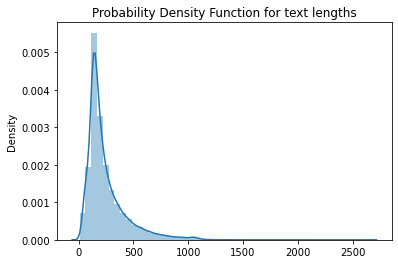

In [133]:
length_as_series = pd.Series(lengths)
plt.title("Probability Density Function for text lengths")
sns.distplot(length_as_series)

In [134]:
max_pad_length = length_as_series.quantile(0.9)

#in order to decrease the runtime of the model training
max_pad_length = 70

reviews = []
labels = []

for i in tqdm(range(len(encoded_texts))):
    if len(encoded_texts[i]) < max_pad_length:
        reviews.append(encoded_texts[i])
        labels.append(labels_as_list[i])
        
assert len(reviews) == len(labels), "The labels and feature lists should have the same time"

  0%|          | 0/37500 [00:00<?, ?it/s]

### Padding tensors

In [135]:
def pad_tensor(review, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(review), seq_length), dtype = int)
    
    review_len = len(review)

    if review_len <= seq_length:
        zeroes = list(np.zeros(seq_length-review_len))
        new = review+zeroes

    return torch.tensor(new)

In [136]:
padded_dataset = []
for i in tqdm(range(len(reviews))):
    padded_dataset.append(pad_tensor(reviews[i], int(max_pad_length)))

  0%|          | 0/2042 [00:00<?, ?it/s]

### transforming lists to tensors and splitting dataset

In [137]:
#preparing the final dataset:
X = torch.stack(padded_dataset)
y = torch.tensor(labels)

In [138]:
(y==1).float().mean()

tensor(0.5642)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=input_test_size,
                                                    random_state=42)

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

<ipython-input-139-6c777cb0064f>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
<ipython-input-139-6c777cb0064f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)


### Creating network and dataset


In [140]:
import math
class NaiveCustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #i_t
        self.W_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        #f_t
        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        #c_t
        self.W_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        #o_t
        self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    
    def forward(self,
                x,
                init_states=None):
        
        """
        assumes x.shape represents (batch_size, sequence_size, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)
            g_t = torch.tanh(x_t @ self.W_c + h_t @ self.U_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        #reshape hidden_seq p/ retornar
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

### Creating network class

In [141]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(encoder.vocab)+1, embedding_dim)
        self.lstm = NaiveCustomLSTM(embedding_dim,hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, 2)
        
    def forward(self, x):
        x_ = self.embedding(x)
        x_, (h_n, c_n) = self.lstm(x_)
        x_ = (x_[:, -1, :])
        x_ = self.fc1(x_)
        return x_

### Creating training objects

In [142]:
ds_train = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=train_batch_size, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=test_batch_size, shuffle=True)

In [143]:
device = torch.device('cpu')
classifier = Net().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training

In [144]:
epoch_bar = tqdm(range(num_of_epochs),
                 desc="Training",
                 position=0,
                 total=2)

acc = 0

for epoch in epoch_bar:
    batch_bar = tqdm(enumerate(train_loader),
                     desc="Epoch: {}".format(str(epoch)),
                     position=1,
                     total=len(train_loader))
    
    for i, (datapoints, labels) in batch_bar:
        
        optimizer.zero_grad()
        
        preds = classifier(datapoints.long().to(device))
        loss = criterion(preds, labels.to(device))
        loss.backward()
        optimizer.step()
        acc = (preds.argmax(dim=1) == labels).float().mean().cpu().item()
        
        if (i + 1) % 50 == 0:
            acc = 0
            
            with torch.no_grad():
                for  i, (datapoints_, labels_) in enumerate(test_loader):
                    preds = classifier(datapoints_.to(device))
                    acc += (preds.argmax(dim=1) == labels_.to(device)).float().sum().cpu().item()
            acc /= len(X_test)

        batch_bar.set_postfix(loss=loss.cpu().item(),
                              accuracy="{:.2f}".format(acc),
                              epoch=epoch)
        batch_bar.update()

        
    epoch_bar.set_postfix(loss=loss.cpu().item(),
                          accuracy="{:.2f}".format(acc),
                          epoch=epoch)
    epoch_bar.update()

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 2:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 3:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 4:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5:   0%|          | 0/12 [00:00<?, ?it/s]